In [1]:
from lib.notebook_imports import *
import itertools
import scipy.cluster.hierarchy as shc
import prince
from scipy import sparse
import plotly.graph_objects as go

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

shap.initjs()

start_time = datetime.now()


The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


# README

READ DATA - wczytywanie danych

PREPARE COLUMN SETS - przygotowanie zestawów kolumn

Staraliśmy się przygotować różnymi algorytmami zestawy kolumn genetycznych.
- ALL_GENES_COLS_900 - wszystkie warianty
- LITERATURE_GENES_COLS_900 - warianty, które dostaliśmy jako opisane w literaturze
- SHAP_IMPORTANT_GENES_COLS_900 - jakieś średnie podejście na podstawie wyników shapa
- BORUTA_* - na podstawie selekcji Boruta
    - *_WITH/WITHOUT_AMH_* - z i bez kolumny amh
    - *_SHORTLIST/LONGLIST_* - jakieś różne wersje
    - SHORTLIST_RANDOM_6_FROM_BORUTA_GENES_LONGLIST_WITH_AMH_900 - losowe 6
    - SHORTLIST_CONST_900 - najlepsze 6 (czy powyżej jakiegoś poziomu jakiegoś parametru) z BORUTA_SHORTLIST_WITH_AMH
    - SHORTLIST_CONST_MOTIVATING_900 - podzbiór 3 motywujacych (na podstawie shapa)
    - SHORTLIST_CONST_DEMOTIVATING_900 - podzbiór 3 motywujacych (na podstawie shapa)
- CHROMOSOME_COLS_DICT - słownik chromosom -> wszystkie warianty z danego chromosomu

BASE MODEL - wytrenowanie modelu 'bazowego', z którym będą porównywane pozostałe. Z czymś trzeba porównywać, żeby wiedzieć czy jest lepiej czy gorzej. Wybraliśmy tu SHORTLIST_CONST_900 jako bazę.

TRAIN EVERY COL SET - trenowanie każdego z zestawów, wypisanie wyników i shap

TRAIN EVERY CHROMOSOME - trenowanie każdego z zestawów dla pojedyńczych chromosomów, wypisanie wyników i shap

BRUTE FORCE - próbowaliśmy trenować brute-force'owo różne kombinacje, żeby zobaczyć mniej więcej czy dany zestaw wróży, jakie są jego górne granice, czy ogólnie ciągnie w lewo, czy w prawo, itp.

# READ DATA

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
DATA_PATH = os.environ.get("DATA_PATH")

In [4]:
data_900 = read_data(DATA_PATH, merge_with_meds=True, merge_with_patient_genes=True, vcf=True,remove_outliers=True)

LGB_PARAMS_BASE, N_FOLDS, ALL_MODEL_SUFFIXES, BASE_COLS_1, BASE_COLS_2, ranking_cols = get_consts()

data_900_df = data_900.input_df.copy()

Converting ds_1_result_num_E2 to float
Converting ds_1_result_num_LH to float
Converting ds_1_result_num_PRG to float
Converting ds_1_result_num_AMH to float
Converting ds_789_result_num_E2 to float
Converting amh_qual_result_num to float
Converting qual_result_num_FSH to float
Converting qual_result_num_DHEAS to float
Converting qual_result_num_Inh_B to float
Converting qual_result_num_TST to float
Converting qual_result_num_anty_TPO to float
Converting qual_result_num_TSH to float
Converting qual_result_num_SHBG to float
weight    0.503356
height    0.492170
bmi       0.460850
dtype: float64
pickups_df:                  981
merged with meds_df:         936
merged with patient_gens_df: 922
merged with poli_changes_df: 922
merged with causes_df: 922
merged with patient_groups_df: 922
merged with body_df: 922

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

# PREPARE COLUMN SETS

In [5]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480


In [6]:
%%time

GENE_COL_SETS = prepare_gene_column_sets(
    data_900,
    LGB_PARAMS_BASE,
    BASE_COLS_2,
    DATA_SERIES_900,
    ['l1', 'l2', 'log_l2', 'mape'],
    call=True
)


ll use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in params. Will use it instead of argument
Found `num_boost_round` in param

In [7]:
for key, cols in asdict(GENE_COL_SETS).items():
    print(f'{key.ljust(40, " ")}: {len(cols)}')

ALL_GENES_COLS_900                      : 672
LITERATURE_GENES_COLS_900               : 18
SHAP_IMPORTANT_GENES_COLS_900           : 99
BORUTA_GENES_LONGLIST_WITH_AMH_900      : 63
BORUTA_GENES_LONGLIST_WITHOUT_AMH_900   : 80
SHORTLIST_RANDOM_6_FROM_BORUTA_GENES_LONGLIST_WITH_AMH_900: 6
BORUTA_GENES_SHORTLIST_WITH_AMH_900     : 1
BORUTA_GENES_SHORTLIST_WITHOUT_AMH_900  : 16


# Features ranking

In [8]:
differences = []
for col in GENE_COL_SETS.ALL_GENES_COLS_900:
    if len(data_900_df[col].unique())>1:
        temp=data_900_df.groupby(col)['day_0_mii'].agg(['mean','count'])
        differences.append(temp.values.reshape(4))
    else:
        differences.append(np.zeros(4))
differences_df = pd.DataFrame(differences, columns = ['gr1_mean','gr1_count','gr2_mean','gr2_count'])
differences_df['diff'] = abs(differences_df['gr1_mean']-differences_df['gr2_mean'])
differences_df['stim'] = (differences_df['gr1_mean']-differences_df['gr2_mean'])<0
differences_df['cols'] = GENE_COL_SETS.ALL_GENES_COLS_900

differences_df.sort_values('diff',ascending = False)[
    (differences_df['gr1_count']>10)&
    (differences_df['gr2_count']>10)&
    (differences_df['diff']>1.5)]

Boolean Series key will be reindexed to match DataFrame index.


gr1_mean  gr1_count   gr2_mean  gr2_count      diff   stim  \
629  6.069444      648.0  11.454545       11.0  5.385101   True   
630  6.012579      636.0  10.217391       23.0  4.204813   True   
43   6.080620      645.0   9.785714       14.0  3.705094   True   
633  6.095975      646.0   9.307692       13.0  3.211717   True   
573  6.206790      648.0   3.363636       11.0  2.843154  False   
417  6.109737      647.0   8.833333       12.0  2.723596   True   
235  6.114198      648.0   8.818182       11.0  2.703984   True   
192  6.061417      635.0   8.750000       24.0  2.688583   True   
73   6.260664      633.0   3.692308       26.0  2.568356  False   
343  6.204019      647.0   3.750000       12.0  2.454019  False   
486  6.084639      638.0   8.428571       21.0  2.343932   True   
261  6.200927      647.0   3.916667       12.0  2.284261  False   
153  6.084772      637.0   8.318182       22.0  2.233409   True   
585  6.104361      642.0   8.235294       17.0  2.130933   True   
470  6.216849      641.0   4.111111       18.0  2.105738  False   
230  8.027397       73.0   5.926621      586.0  2.100776  False   
634  6.196291      647.0   4.166667       12.0  2.029624  False   
501  6.208398      643.0   4.187500       16.0  2.020898  False   
554  6.301146      611.0   4.354167       48.0  1.946979  False   
272  6.077778      630.0   7.931034       29.0  1.853257   True   
158  6.200311      644.0   4.400000       15.0  1.800311  False   
586  6.107812      640.0   7.894737       19.0  1.786924   True   
589  6.107812      640.0   7.894737       19.0  1.786924   True   
592  6.107812      640.0   7.894737       19.0  1.786924   True   
651  6.304132      605.0   4.537037       54.0  1.767095  False   
161  6.278232      611.0   4.645833       48.0  1.632399  False   
13   6.112500      640.0   7.736842       19.0  1.624342   True   
225  6.296849      603.0   4.678571       56.0  1.618278  False   
180  6.210031      638.0   4.619048       21.0  1.590984  False   
112  7.681818       22.0   6.106750      637.0  1.575068  False   
211  7.397163      141.0   5.822394      518.0  1.574769  False   
245  6.275410      610.0   4.714286       49.0  1.561124  False   
252  6.258117      616.0   4.744186       43.0  1.513931  False   
92   6.236800      625.0   4.735294       34.0  1.501506  False   
382  4.724138       29.0   6.225397      630.0  1.501259   True   
383  4.724138       29.0   6.225397      630.0  1.501259   True   
320  6.266340      612.0   4.765957       47.0  1.500382  False   

                           cols  
629        SOX9_17_72123461_G_-  
630        SOX9_17_72123628_C_-  
43            AR_X_67544940_C_A  
633      SOX9_17_72124489_G_TGT  
573         PRLR_5_35072610_T_G  
417        LHCGR_2_48694236_T_C  
235   ESR2_14_64226699_-_TTTTTT  
192        ESR1_6_152098584_C_T  
73            AR_X_67722634_A_G  
343         FSHR_2_48989016_C_T  
486        OTHER_6_22287169_A_T  
261        ESR2_14_64235053_A_G  
153        ESR1_6_151808173_G_-  
585         PRLR_5_35229973_C_A  
470        OTHER_2_48686681_A_G  
230        ESR2_14_64226599_T_C  
634        SOX9_17_72124635_A_G  
501       PRLR_5_35055852_GC_TT  
554         PRLR_5_35064922_C_G  
272        ESR2_14_64280216_-_A  
158        ESR1_6_151808453_C_T  
586         PRLR_5_35230018_C_A  
589         PRLR_5_35230124_G_A  
592         PRLR_5_35230200_G_C  
651  SOX9_17_72126087_TTTTTTT_-  
161        ESR1_6_151842149_A_G  
13        AMHR2_12_53431536_T_C  
225        ESR1_6_152102770_T_A  
180        ESR1_6_152011609_G_A  
112           AR_X_67730263_C_T  
211        ESR1_6_152101200_C_T  
245        ESR2_14_64227364_T_C  
252        ESR2_14_64228031_T_G  
92            AR_X_67726853_G_C  
382        GDF9_5_132866707_T_C  
383        GDF9_5_132866719_C_G  
320        FSHB_11_30234748_T_G

In [9]:
cutoff_diff = 1.5

In [10]:
stim_cols_less = differences_df.sort_values('diff',ascending = False)[
    (differences_df['gr1_count']>10)&
    (differences_df['gr2_count']>10)&
    (differences_df['diff']>cutoff_diff)&
    (differences_df['stim'])&
    (differences_df['gr2_count']<100)]['cols'].to_list()
stim_cols_more = differences_df.sort_values('diff',ascending = False)[
    (differences_df['gr1_count']>10)&
    (differences_df['gr2_count']>10)&
    (differences_df['diff']>cutoff_diff)&
    (differences_df['stim'])&
    (differences_df['gr1_count']<100)]['cols'].to_list()
destim_cols_less = differences_df.sort_values('diff',ascending = False)[
    (differences_df['gr1_count']>10)&
    (differences_df['gr2_count']>10)&
    (differences_df['diff']>cutoff_diff)&
    ~(differences_df['stim'])&
    (differences_df['gr2_count']<100)]['cols'].to_list()
destim_cols_more = differences_df.sort_values('diff',ascending = False)[
    (differences_df['gr1_count']>10)&
    (differences_df['gr2_count']>10)&
    (differences_df['diff']>cutoff_diff)&
    ~(differences_df['stim'])&
    (differences_df['gr1_count']<100)]['cols'].to_list()

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [11]:
stim_cols_more

['GDF9_5_132866707_T_C', 'GDF9_5_132866719_C_G']

In [12]:
data_900_df['stim_cols_less'] = data_900_df[stim_cols_less].sum(axis = 1)
data_900_df['stim_cols_more'] = data_900_df[stim_cols_more].sum(axis = 1)
data_900_df['destim_cols_less'] = data_900_df[destim_cols_less].sum(axis = 1)
data_900_df['destim_cols_more'] = data_900_df[destim_cols_more].sum(axis = 1)

In [13]:
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[fold_avg][l2]

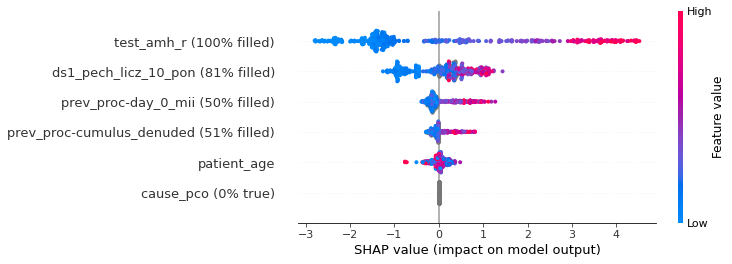

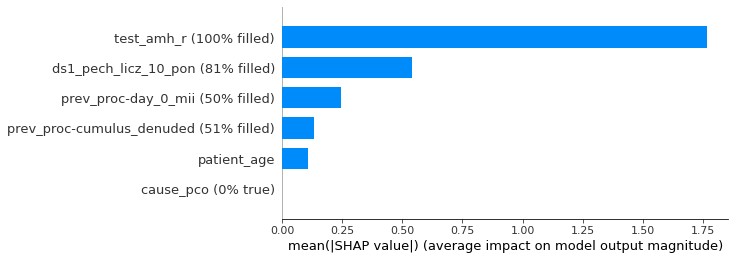

In [24]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[fold_avg][l2]

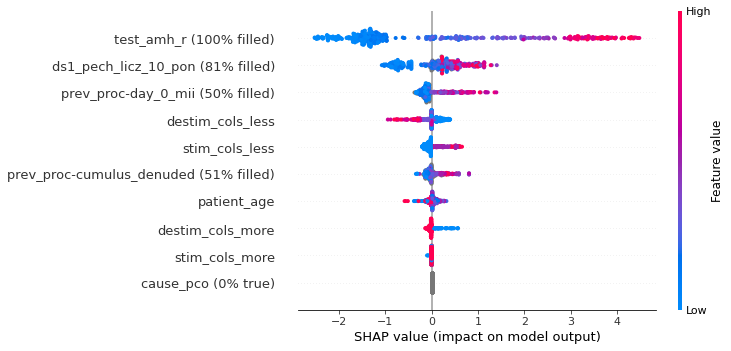

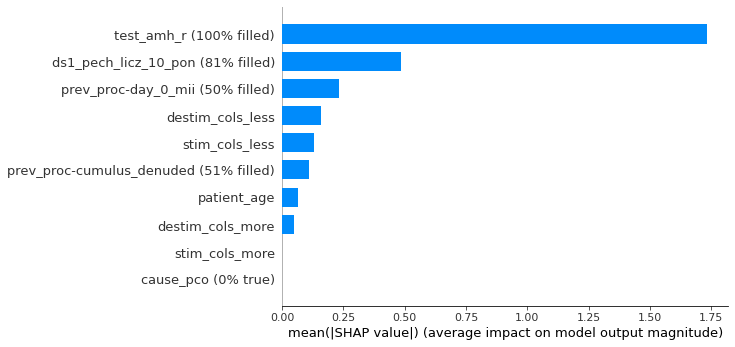

In [14]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'stim_cols_less',
    'stim_cols_more',
    'destim_cols_less',
    'destim_cols_more'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

In [15]:
stim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE)
stim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,less=False)
destim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False)
destim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False,less = False)

Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the pa

Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

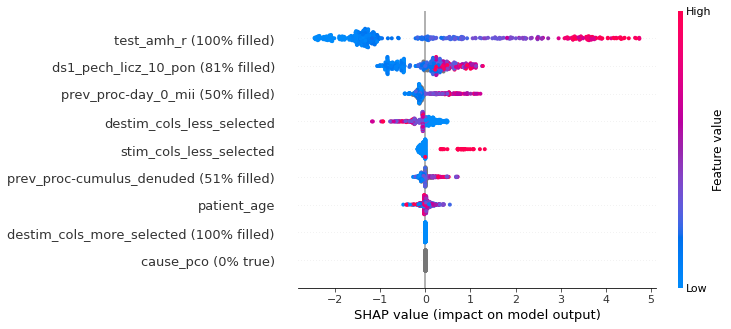

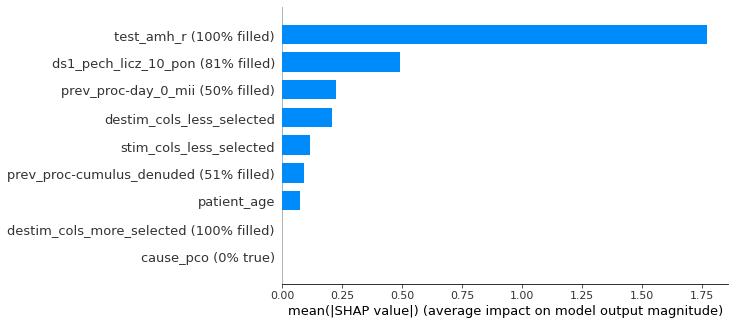

In [20]:
data_900_df['stim_cols_less_selected'] = data_900_df[stim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_less_selected'] = data_900_df[destim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_more_selected'] = data_900_df[destim_cols_more_selected].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'stim_cols_less_selected',
    'destim_cols_less_selected',
    'destim_cols_more_selected'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

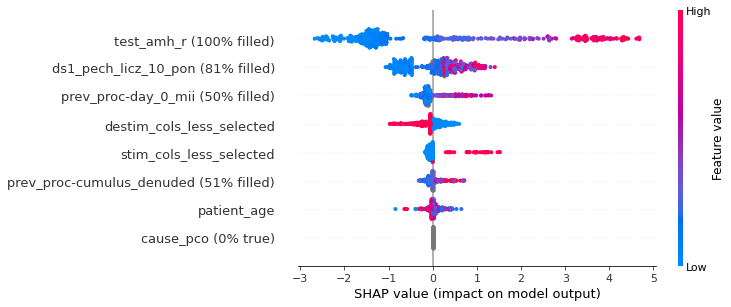

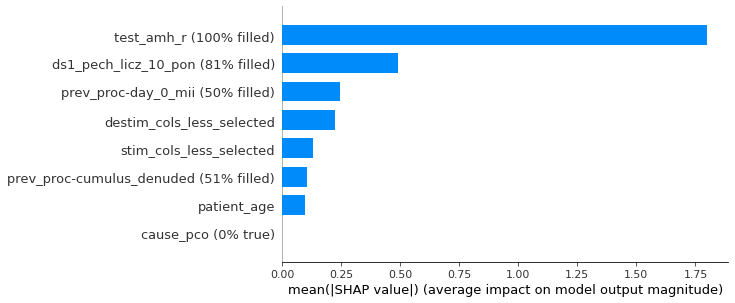

In [21]:
data_900_df['stim_cols_less_selected'] = (data_900_df[stim_cols_less_selected].sum(axis = 1)>0)*1
data_900_df['destim_cols_less_selected'] = (data_900_df[destim_cols_less_selected].sum(axis = 1)>0)*1
data_900_df['destim_cols_more_selected'] = (data_900_df[destim_cols_more_selected].sum(axis = 1)>0)*1
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",            
    'stim_cols_less_selected',
    'destim_cols_less_selected',
    #'destim_cols_more_selected'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[fold_avg][l2]

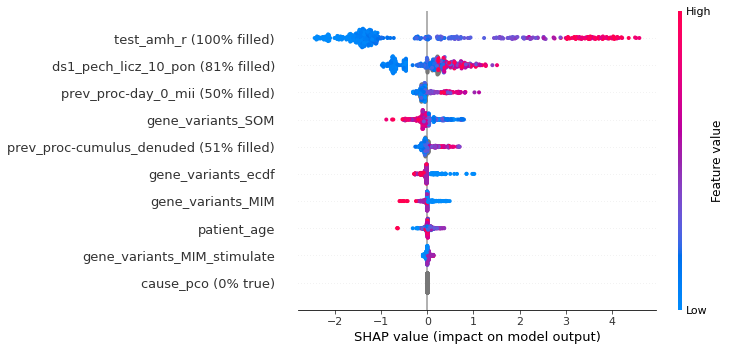

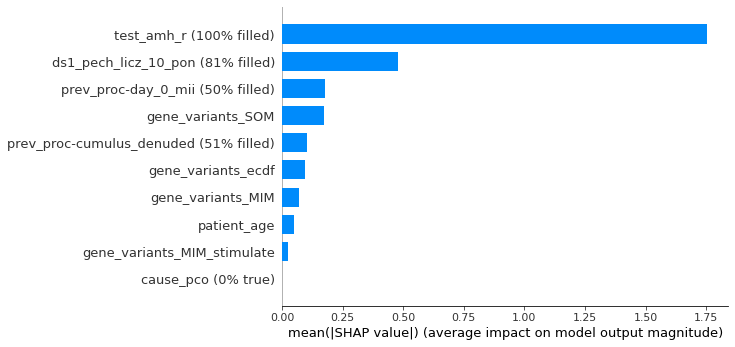

In [22]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    'gene_variants_ecdf',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  13
Removed records:  76
Removed records:  14
Filtered records: 494
Original records: 845
Removed records:  248
Removed records:  0
Removed records:  0
Removed records:  29
Removed records:  74
Removed records:  14
Filtered records: 480
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

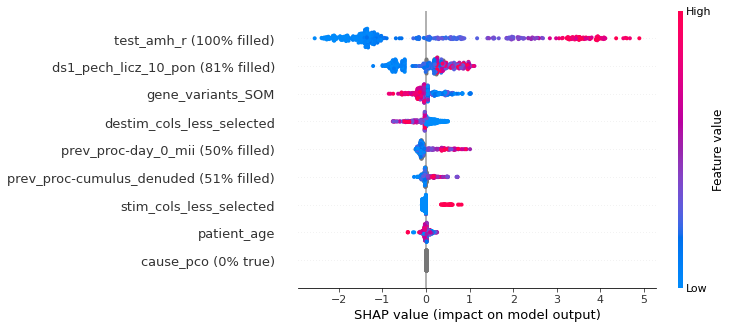

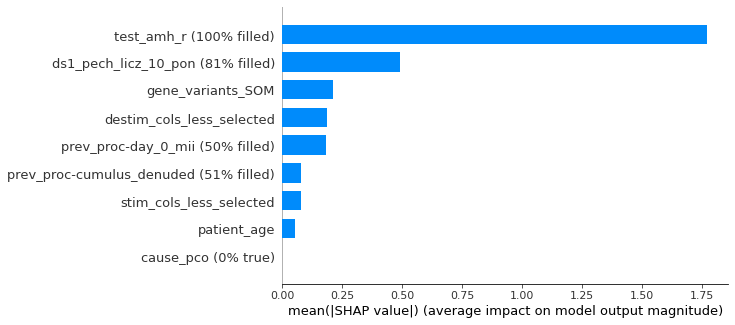

In [25]:
data_900_df['stim_cols_less_selected'] = data_900_df[stim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_less_selected'] = data_900_df[destim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_more_selected'] = data_900_df[destim_cols_more_selected].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)

GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    #'gene_variants_ecdf',
    'gene_variants_SOM',
    #'gene_variants_MIM_stimulate',
    #'gene_variants_MIM',
    'stim_cols_less_selected',
    'destim_cols_less_selected',
    #'destim_cols_more_selected'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

In [107]:
stim_cols_less_selected

['SOX9_17_72123628_C_-',
 'ESR2_14_64226699_-_TTTTTT',
 'ESR1_6_152098584_C_T',
 'OTHER_6_22287169_A_T',
 'ESR1_6_151808173_G_-',
 'AMHR2_12_53431536_T_C']

In [108]:
destim_cols_less_selected

['PRLR_5_35072610_T_G',
 'AR_X_67722634_A_G',
 'PRLR_5_35055852_GC_TT',
 'PRLR_5_35064922_C_G',
 'SOX9_17_72126087_TTTTTTT_-',
 'ESR1_6_151842149_A_G',
 'ESR1_6_152102770_T_A',
 'ESR1_6_152011609_G_A',
 'ESR2_14_64227364_T_C',
 'ESR2_14_64228031_T_G']

In [110]:
gene_variants_SOM=[
            'GDF9_5_132865538_T_C', 
            'GDF9_5_132866205_T_C',
            'PRL_6_22292747_A_T', 
            'AR_X_67723521_-_CACACAC', 
            'LHCGR_2_48729336_C_T',
            'FSHB_11_30234435_A_G',
            'FSHR_2_48963902_C_T___Missense Variant',
            'ESR1_6_152098960_G_A',
            'ESR1_6_152061190_A_G',
            'PRLR_5_35069955_T_A',
            'ESR2_14_64227477_C_T'
           ]
gene_variants_SOM

['GDF9_5_132865538_T_C',
 'GDF9_5_132866205_T_C',
 'PRL_6_22292747_A_T',
 'AR_X_67723521_-_CACACAC',
 'LHCGR_2_48729336_C_T',
 'FSHB_11_30234435_A_G',
 'FSHR_2_48963902_C_T___Missense Variant',
 'ESR1_6_152098960_G_A',
 'ESR1_6_152061190_A_G',
 'PRLR_5_35069955_T_A',
 'ESR2_14_64227477_C_T']

In [111]:
list(set(gene_variants_SOM).intersection(destim_cols_less_selected))

[]

# Data with outliers

In [26]:
data_900 = read_data(DATA_PATH, merge_with_meds=True, merge_with_patient_genes=True, vcf=True,remove_outliers=False)
data_900_df = data_900.input_df.copy()

Converting ds_1_result_num_E2 to float
Converting ds_1_result_num_LH to float
Converting ds_1_result_num_PRG to float
Converting ds_1_result_num_AMH to float
Converting ds_789_result_num_E2 to float
Converting amh_qual_result_num to float
Converting qual_result_num_FSH to float
Converting qual_result_num_DHEAS to float
Converting qual_result_num_Inh_B to float
Converting qual_result_num_TST to float
Converting qual_result_num_anty_TPO to float
Converting qual_result_num_TSH to float
Converting qual_result_num_SHBG to float
weight    0.503356
height    0.492170
bmi       0.460850
dtype: float64
pickups_df:                  981
merged with meds_df:         936
merged with patient_gens_df: 922
merged with poli_changes_df: 922
merged with causes_df: 922
merged with patient_groups_df: 922
merged with body_df: 922

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [27]:
differences = []
for col in GENE_COL_SETS.ALL_GENES_COLS_900:
    if len(data_900_df[col].unique())>1:
        temp=data_900_df.groupby(col)['day_0_mii'].agg(['mean','count'])
        differences.append(temp.values.reshape(4))
    else:
        differences.append(np.zeros(4))
differences_df = pd.DataFrame(differences, columns = ['gr1_mean','gr1_count','gr2_mean','gr2_count'])
differences_df['diff'] = abs(differences_df['gr1_mean']-differences_df['gr2_mean'])
differences_df['stim'] = (differences_df['gr1_mean']-differences_df['gr2_mean'])<0
differences_df['cols'] = GENE_COL_SETS.ALL_GENES_COLS_900


In [28]:
stim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE)
stim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,less=False)
destim_cols_less_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False)
destim_cols_more_selected = rarest_variants_combinations(data_900_df,differences_df,LGB_PARAMS_BASE,stim=False,less = False)

Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the pa

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[fold_avg][l2]

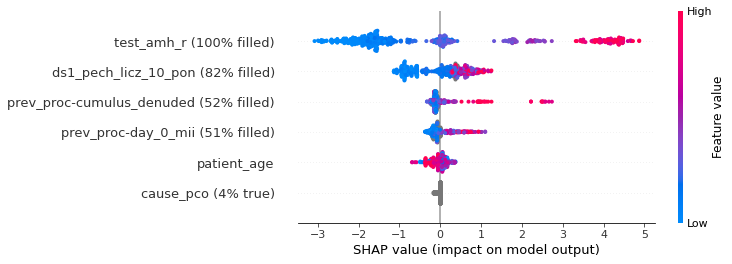

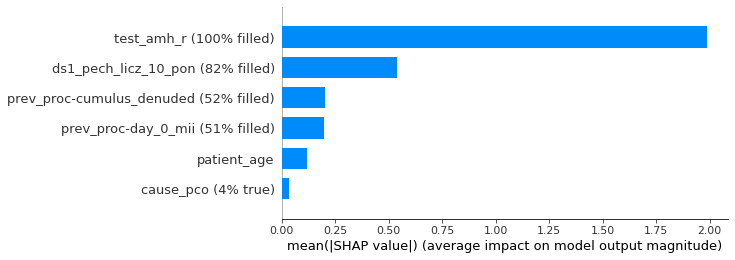

In [50]:
REF_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco"
]
REF_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    REF_ADD_COLS,
    model_suffixes_filter=['l2'])
REF_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    REF_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))
REF_RESULTS_df = REF_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
REF_RESULTS_df['error'] = REF_RESULTS_df['day_0_mii']-REF_RESULTS_df['prediction_l2']

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

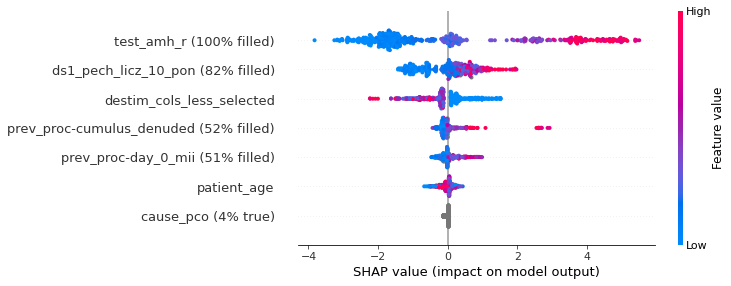

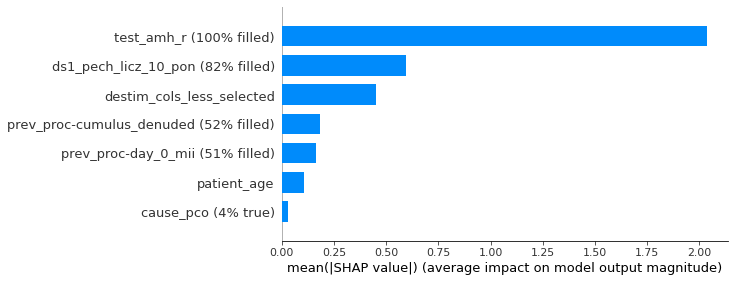

In [29]:
data_900_df['stim_cols_less_selected'] = data_900_df[stim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_less_selected'] = data_900_df[destim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_more_selected'] = data_900_df[destim_cols_more_selected].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    #'stim_cols_less_selected',
    'destim_cols_less_selected',
    #'destim_cols_more_selected'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
-
RMSE[fold_avg][l2]

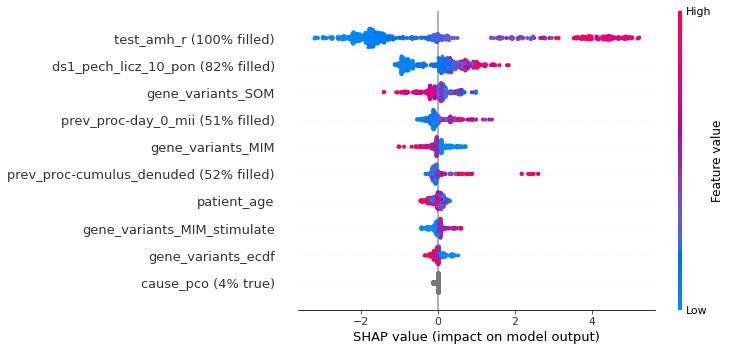

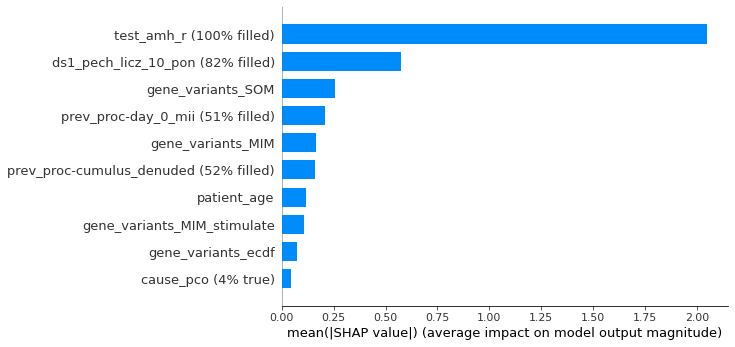

In [30]:
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    'gene_variants_ecdf',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

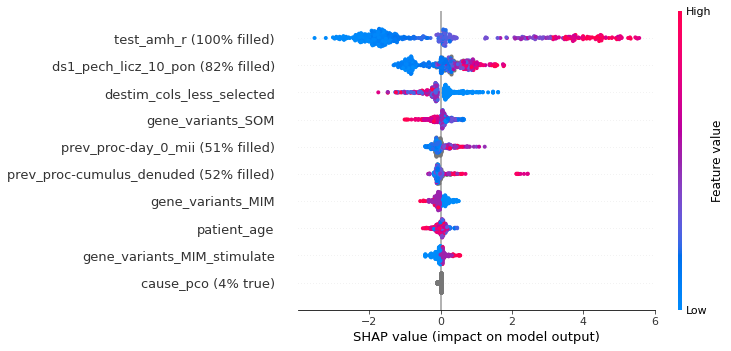

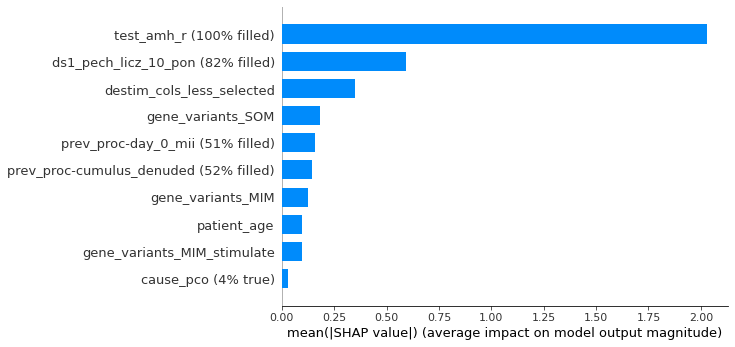

In [33]:
data_900_df['stim_cols_less_selected'] = data_900_df[stim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_less_selected'] = data_900_df[destim_cols_less_selected].sum(axis = 1)
data_900_df['destim_cols_more_selected'] = data_900_df[destim_cols_more_selected].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",         
    #'stim_cols_less_selected',
    'destim_cols_less_selected',
    #'destim_cols_more_selected',
    #'gene_variants_ecdf',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
shap_vals,all_train_dfs = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))

In [34]:
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('900_day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['day_0_mii']-GENE_RESULTS_df['prediction_l2']

In [72]:
biggest_genes_impact = GENE_RESULTS_df.iloc[np.where(abs(shap_vals[:,6:]).sum(axis = 1)>1)[0]].index

In [73]:
len(biggest_genes_impact)

128

3.995648012354808


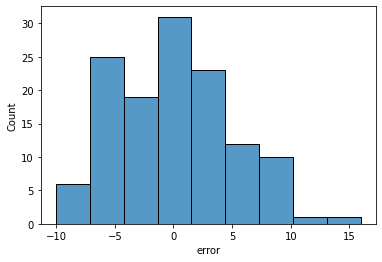

In [74]:
sns.histplot(GENE_RESULTS_df.loc[biggest_genes_impact],x='error')
print(GENE_RESULTS_df.loc[biggest_genes_impact,'error'].abs().mean())

4.225640265321872


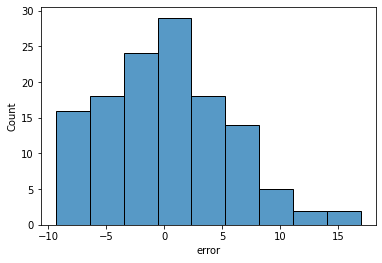

In [75]:
sns.histplot(REF_RESULTS_df.loc[biggest_genes_impact],x='error')
print(REF_RESULTS_df.loc[biggest_genes_impact,'error'].abs().mean())

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

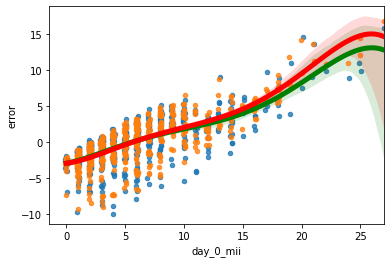

In [77]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df,
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

<AxesSubplot:xlabel='day_0_mii', ylabel='error'>

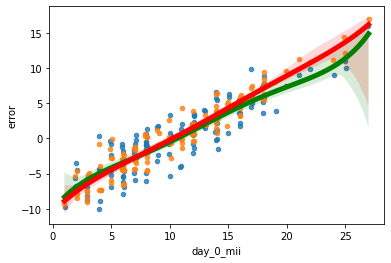

In [78]:
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=GENE_RESULTS_df.loc[biggest_genes_impact],
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'green'},
    order=5)
sns.regplot(
    y="error", 
    x="day_0_mii",    
    data=REF_RESULTS_df.loc[biggest_genes_impact],
    x_jitter=.1,
    ci = 95,
    scatter_kws={"s": 20},
    line_kws={'lw':5,
    'color':'red'},
    order=5)

# Testy statystyczne różnicy rozkładu MII w wariantach genetycznych

In [79]:
from scipy.stats import kruskal,mannwhitneyu,kstest

In [193]:
kruskal(data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==True,
'day_0_mii'],data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==False,'day_0_mii'],
 nan_policy = 'omit')

KruskalResult(statistic=4.885552499885604, pvalue=0.027082365430105285)

In [209]:
mannwhitneyu(data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==True,'day_0_mii'],
data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==False,'day_0_mii'])

In [205]:
len(data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==True,'day_0_mii'])*len(data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==False,'day_0_mii'])/2

49335.0

In [203]:
kstest(data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==True,'day_0_mii'],
data_900_df_mii.loc[data_900_df_mii['GDF9_5_132865378_C_T']==False,'day_0_mii'])

KstestResult(statistic=0.08772676598763555, pvalue=0.18525147375453122)

p<0.05 => różnica w rozkładach

In [86]:
data_900_df_mii = data_900_df.loc[pd.notna(data_900_df['mii_group'])].copy()
data_900_df_mii.reset_index(drop = True,inplace = True)

In [105]:
gene_column_list = GENE_COL_SETS.ALL_GENES_COLS_900
gene_columns_test = []
for gene_column in gene_column_list:
    if len(data_900_df_mii[gene_column].unique())>1:
        mwu_less = mannwhitneyu(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'less')
        mwu_greater = mannwhitneyu(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'greater')
        ks_less = kstest(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'less')
        ks_greater = kstest(data_900_df_mii.loc[data_900_df_mii[gene_column]==True,'day_0_mii'],
        data_900_df_mii.loc[data_900_df_mii[gene_column]==False,'day_0_mii'],
        alternative = 'greater')
        gene_columns_test.append([
            gene_column,
            mwu_less[0],
            mwu_less[1],
            mwu_greater[0],
            mwu_greater[1],
            ks_less[0],
            ks_less[1],
            ks_greater[0],
            ks_greater[1],
            data_900_df.groupby(gene_column)[gene_column].count().min()
            ])
    else:
        gene_columns_test.append([gene_column,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
gene_columns_test = pd.DataFrame(gene_columns_test, columns = [
    'column_name',
    'mwu_less_stat',
    'mwu_less_p',
    'mwu_greater_stat',
    'mwu_greater_p',
    'ks_less_stat',
    'ks_less_p',
    'ks_greater_stat',
    'ks_greater_p',
    'count'])

In [106]:
gene_columns_test.loc[(gene_columns_test['ks_less_p']<0.05)&
(gene_columns_test['count']>20),'column_name'].to_list()

['AR_X_67544940_C_A',
 'AR_X_67545395_C_-',
 'ESR2_14_64280216_-_A',
 'LHCGR_2_48729336_C_T',
 'LHCGR_2_48755729_C_A',
 'OTHER_6_22287169_A_T',
 'PRLR_5_35229973_C_A',
 'PRLR_5_35230018_C_A',
 'PRLR_5_35230124_G_A',
 'PRLR_5_35230200_G_C',
 'PRLR_5_35230278_G_C',
 'PRLR_5_35230396_G_A',
 'SOX9_17_72123628_C_-']

AR_X_67544940_C_A
AR_X_67544940_C_A
False    899
True      23
Name: AR_X_67544940_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

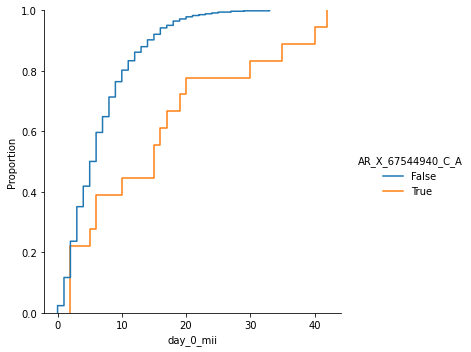

AR_X_67545395_C_-
AR_X_67545395_C_-
False    894
True      28
Name: AR_X_67545395_C_-, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

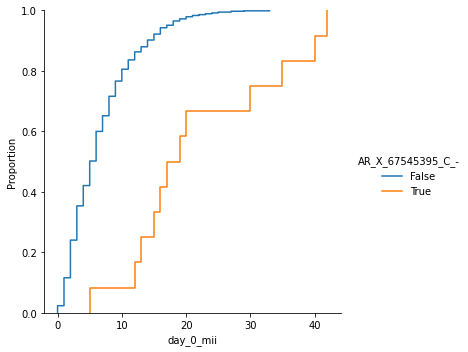

ESR2_14_64280216_-_A
ESR2_14_64280216_-_A
False    866
True      56
Name: ESR2_14_64280216_-_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

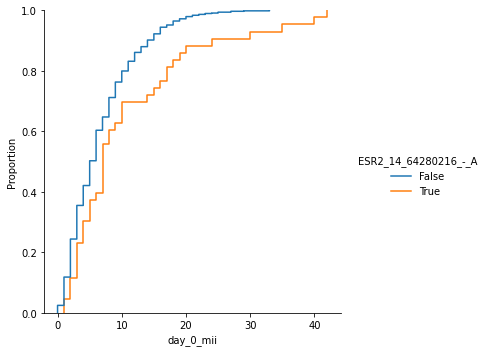

LHCGR_2_48729336_C_T
LHCGR_2_48729336_C_T
False    510
True     412
Name: LHCGR_2_48729336_C_T, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

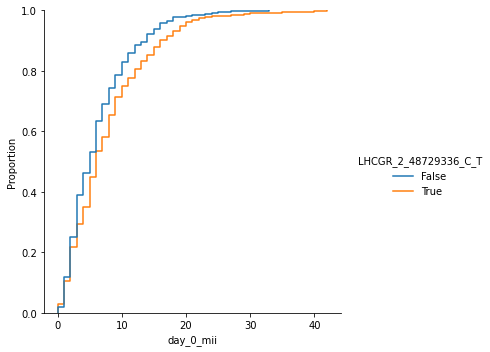

LHCGR_2_48755729_C_A
LHCGR_2_48755729_C_A
False    767
True     155
Name: LHCGR_2_48755729_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

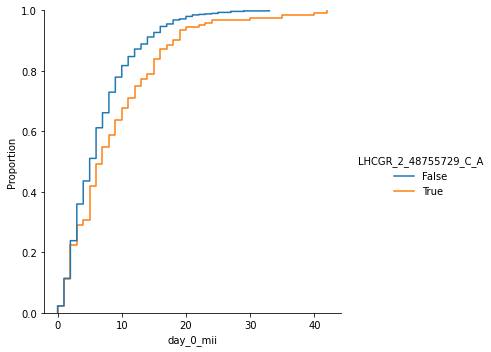

OTHER_6_22287169_A_T
OTHER_6_22287169_A_T
False    892
True      30
Name: OTHER_6_22287169_A_T, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

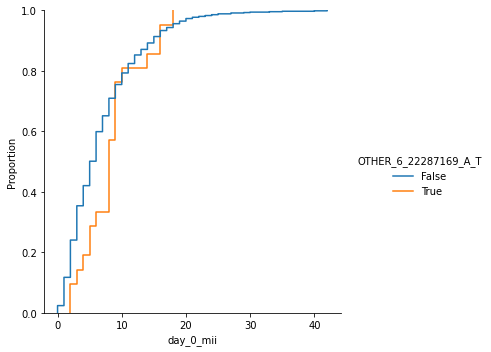

PRLR_5_35229973_C_A
PRLR_5_35229973_C_A
False    888
True      34
Name: PRLR_5_35229973_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

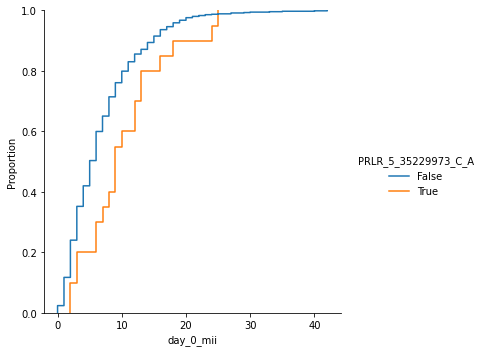

PRLR_5_35230018_C_A
PRLR_5_35230018_C_A
False    886
True      36
Name: PRLR_5_35230018_C_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

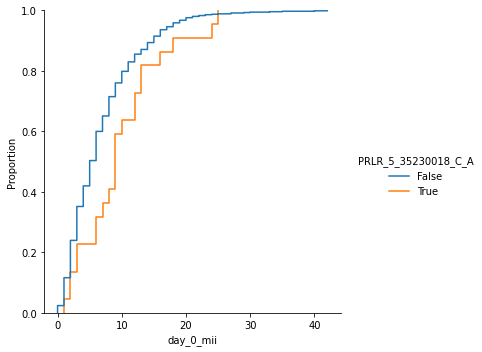

PRLR_5_35230124_G_A
PRLR_5_35230124_G_A
False    886
True      36
Name: PRLR_5_35230124_G_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

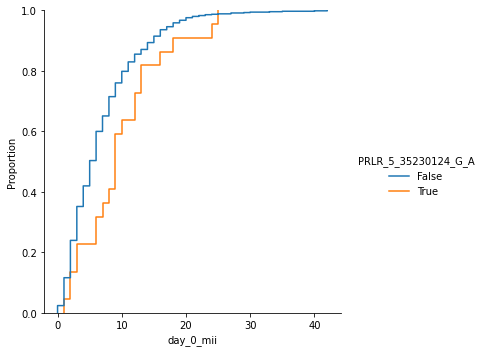

PRLR_5_35230200_G_C
PRLR_5_35230200_G_C
False    886
True      36
Name: PRLR_5_35230200_G_C, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

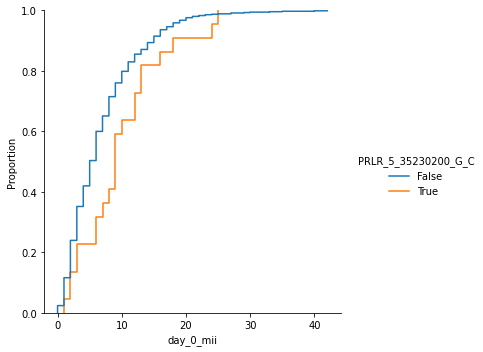

PRLR_5_35230278_G_C
PRLR_5_35230278_G_C
False    875
True      47
Name: PRLR_5_35230278_G_C, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

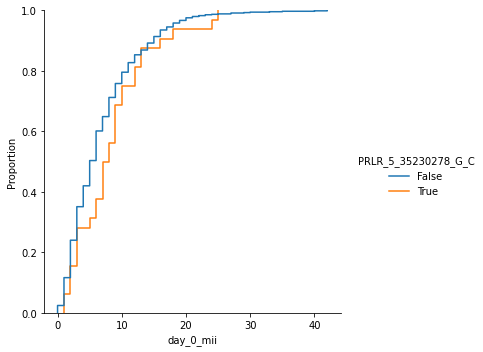

PRLR_5_35230396_G_A
PRLR_5_35230396_G_A
False    871
True      51
Name: PRLR_5_35230396_G_A, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

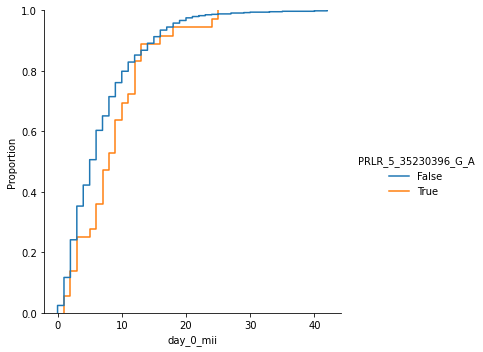

SOX9_17_72123628_C_-
SOX9_17_72123628_C_-
False    872
True      50
Name: SOX9_17_72123628_C_-, dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

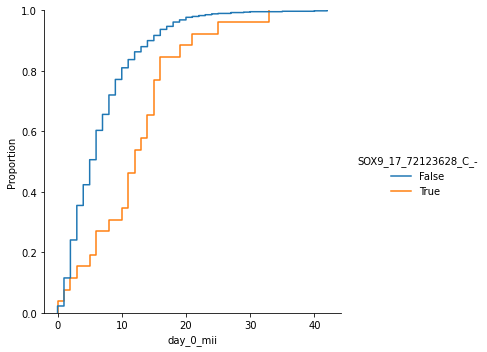

<Figure size 432x288 with 0 Axes>

In [107]:
gene_column_list = gene_columns_test.loc[(gene_columns_test['ks_less_p']<0.05)&
(gene_columns_test['count']>20),'column_name'].to_list()
for gene_column in gene_column_list:
    #sns.displot(data_900_df, x="day_0_mii", hue=gene_column, kind="kde")
    print(gene_column)
    print(data_900_df.groupby(gene_column)[gene_column].count())
    plt.figure()
    sns.displot(data_900_df, x="day_0_mii", hue=gene_column, kind="ecdf")
    plt.show()
    plt.clf()

In [127]:
gene_column_list = gene_columns_test.loc[(gene_columns_test['ks_greater_p']<0.05)&
(gene_columns_test['count']>10),'column_name'].to_list()

gene_column_list = [x for x in gene_column_list if x not in (list(set(gene_column_list).intersection(destim_cols_less_selected)))]

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530
Original records: 922
Removed records:  268
Removed records:  0
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in pa

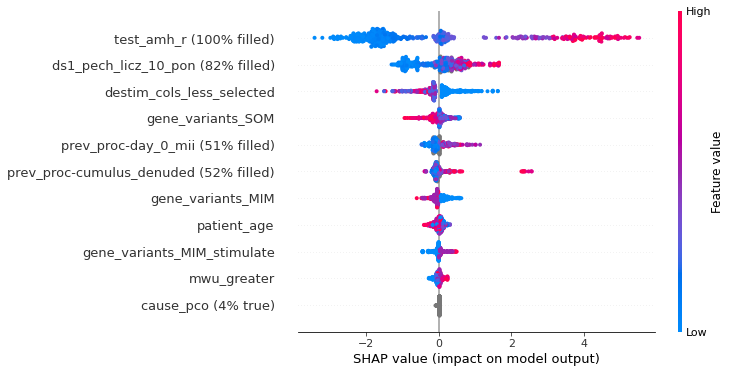

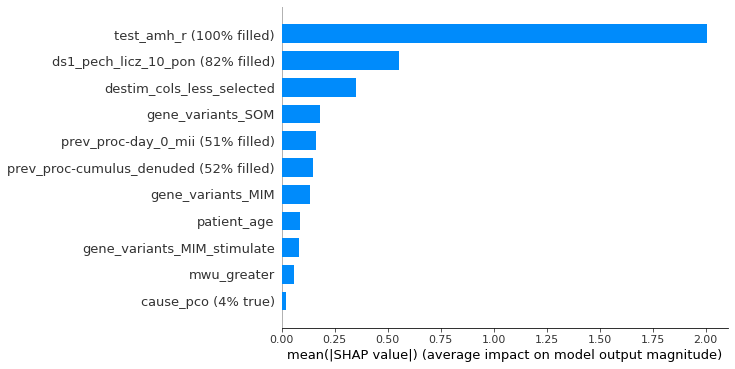

In [131]:
data_900_df['ks_greater'] = data_900_df[gene_column_list].sum(axis = 1)
DATA_SERIES_900 = {}
DATA_SERIES_900['900_cumulus_denuded'] = prepare_data_serie(data_900_df, 'cumulus_denuded', N_FOLDS)
DATA_SERIES_900['900_day_0_mii'] = prepare_data_serie(data_900_df, 'day_0_mii', N_FOLDS)
GENE_ADD_COLS = [
    "test_amh_r",
    "ds1_pech_licz_10_pon",
    "patient_age",
    "prev_proc-cumulus_denuded",
    "prev_proc-day_0_mii",
    "cause_pco",
    'destim_cols_less_selected',
    'gene_variants_SOM',
    'gene_variants_MIM_stimulate',
    'gene_variants_MIM',
    'mwu_greater',
    #'ks_greater'
]
GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    GENE_ADD_COLS,
    model_suffixes_filter=['l2'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['l2'],
    print_avg=True,
)
a,b = explain_model(
    GENE_RESULTS,
    data_serie_name='900_day_0_mii',
    model_suffix='l2',
    folds=range(0, N_FOLDS))